In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
torch.cuda.empty_cache()

from fastai.vision.all import *
from fastai.callback.all import *


In [ ]:
model_path = Path('../models')
path = Path('../data')

In [3]:
cell_df = pd.read_csv(path/'cells_sample.csv')
cell_df.head()

,image_id,image_labels
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0
1,6166673c-bbad-11e8-b2ba-ac1f6b6435d0,0
2,2533bcc2-bba5-11e8-b2ba-ac1f6b6435d0,0
3,280f88c2-bba5-11e8-b2ba-ac1f6b6435d0,0
4,13669cc6-bbaa-11e8-b2ba-ac1f6b6435d0,0


In [4]:
def get_x(r): return path/'train'/f"{r['image_id']}.png"
def get_y(r): return r['image_labels'].split('|')

In [5]:
def get_dls(bs: int, size: int):
    return DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                     splitter=RandomSplitter(seed=42),
                     get_x=get_x,
                     get_y=get_y,
                     batch_tfms=aug_transforms(size=size, min_scale=0.75))\
        .dataloaders(cell_df, bs=bs, num_workers=0)

In [6]:
batch_size = 64
image_size = 256

dls = get_dls(batch_size, image_size)

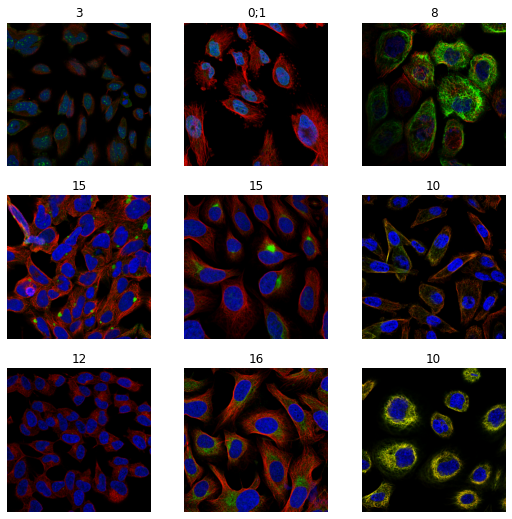

In [7]:
dls.show_batch()

## Choose Model:
Vi har valgt at bruge et residualt netværk, som er trænet på ImageNet.
I vores model er det kun et netværk med 18 lag, så vi ikke skal vente hundrede år mellem hver træning,
når vi eksperimenterer med modellen.
Derudover så vi ikke en markant højere præcision, da vi trænede med modellen med 50 lag.
Det kan også ses, at vi bruger fp16 for at spare regnekraft mens vi træner.

In [8]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2)).to_fp16()

In [9]:
# learn.lr_find()

In [10]:
x = dls.one_batch()[0][0].unsqueeze(0)

In [11]:
print(x.shape)
print(x)


torch.Size([1, 3, 256, 256])
TensorImage([[[[-2.1179, -2.1179, -2.1179,  ..., -1.1984, -0.3295, -1.9463],
          [-2.1179, -2.1179, -2.1179,  ..., -1.2271, -1.2184,  1.7840],
          [-2.1179, -2.1179, -2.1179,  ..., -0.3415,  0.8449, -1.4696],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0230, -1.9885, -1.9012],
          [-2.0357, -2.0357, -2.0356,  ..., -2.0059, -1.9694, -1.8358],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0071, -1.8223, -1.9729],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0351, -2.0308, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0344, -2.0183, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0340, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.804

In [12]:
with learn.no_bar():
    learn.fine_tune(1, base_lr=0.03)

[0, 0.3466063439846039, 0.21542270481586456, 0.8984394073486328, '01:17']
[0, 0.19426928460597992, 0.16362549364566803, 0.9295161962509155, '01:15']


In [13]:
class Hook:
    def hook_func(self, model, input, output):
        self.stored = output.detach().clone()

In [14]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [15]:
with torch.no_grad(): output = learn.model.eval()(x)

In [16]:
act = hook_output.stored[0]

In [17]:
F.softmax(output, dim=-1)

tensor([[3.0634e-02, 4.2359e-02, 7.1224e-04, 3.2486e-04, 1.0445e-01, 4.9358e-03,
         1.8910e-03, 2.0509e-02, 4.7175e-03, 7.9694e-02, 1.8710e-03, 3.4437e-02,
         4.7948e-02, 2.5437e-02, 5.6893e-01, 5.0554e-03, 1.8470e-02, 1.9610e-03,
         5.6692e-03]], device='cuda:0')

In [18]:
dls.vocab

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9']

In [19]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([19, 8, 8])

In [20]:
cam_map[1]


tensor([[-3.6638, -5.0014, -4.6641, -5.3038, -5.4285, -4.2550, -3.1128, -3.5075],
        [-3.6102, -4.4941, -4.2515, -7.2059, -5.6678, -4.7822, -3.6120, -3.4762],
        [-3.5570, -3.8619, -3.5771, -6.1397, -4.5253, -7.8883, -5.3511, -4.8685],
        [-3.5531, -3.0994, -3.1100, -3.6591, -4.7113, -6.4727, -5.6189, -5.5836],
        [-2.8050, -2.1106, -2.6849, -2.8078, -3.5548, -5.4592, -6.3469, -6.3535],
        [-3.1046, -2.4743, -3.3878, -2.7798, -1.8858, -4.9715, -5.4210, -6.1179],
        [-3.6859, -2.7099, -1.6939, -0.4566,  0.4863, -1.7106, -4.2832, -5.5826],
        [-4.0879, -4.2750, -2.8365, -1.7611, -1.1887, -1.3875, -2.9639, -4.0270]],
       device='cuda:0', grad_fn=<SelectBackward>)

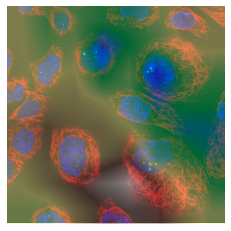

In [21]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.5, extent=(0,256,256,0), interpolation='bilinear', cmap='terrain')

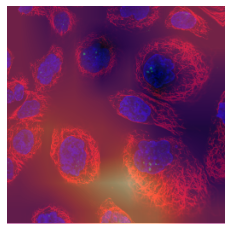

In [22]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,256,256,0), interpolation='bilinear', cmap='magma')

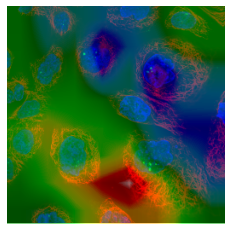

In [23]:
# DIS IS DA ONE!
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.5, extent=(0,256,256,0), interpolation='bilinear', cmap='nipy_spectral')

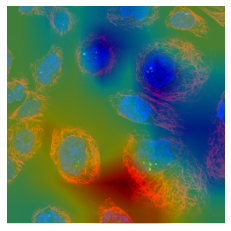

In [24]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.5, extent=(0,256,256,0), interpolation='bilinear', cmap='jet')

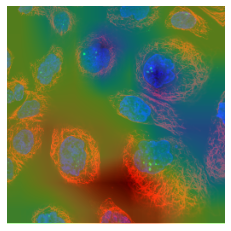

In [25]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.5, extent=(0,256,256,0), interpolation='bilinear', cmap='turbo')

In [26]:
class HeatMapper(HookCallback):
    def hook_func(self, model, input, output):
        self.stored = output.detach().clone()

    def after_batch(self):
        if self.training:
            with torch.no_grad(): self.output = self.learn.model.eval()(x)

## Evaluation:
Til vores models metric bruger vi standard præcision for multicategory, hvilket er accuracy_multi.
Vi vil dog gerne have en threshhold på 0.2, derfor er vi nød til at give mertics en partial,
hvilket betyder at der laves en ny version af accuracy_multi, hvor threshold er den værdi vi sender med i partial.

## Tuning:
Da vi har valgt at bruge en på-forhånd trænet model, ResNet, er vi nød til at finjustere den til vores problem.
Dette gøres ved at kalde fine_tune på vores learner.
fine_tune smider det sidste linære lag i modellen væk og skifter det ud med et nyt linært lag.
Dernæst fryser modellen vægtene i alle de gamle lag, og træner nu det nye linære lag i en epoche.
Derefter tøes de frosne lag op og modellen trænes nu sammen i det ønskede antal gange - her er det 5.

På denne måde undgår vi at smide alt den træning modellen har fra ImageNet væk,
og modellen bliv

In [27]:
# hook = HeatMapper()

learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2)).to_fp16()

with learn.no_bar():
    learn.fine_tune(5, base_lr=0.03)



[0, 0.3507911264896393, 0.2267654687166214, 0.9035969376564026, '01:11']
[0, 0.1964944452047348, 0.19478283822536469, 0.9124240875244141, '01:18']
[1, 0.17435261607170105, 0.19674929976463318, 0.9057129621505737, '01:14']
[2, 0.1548372358083725, 0.15657766163349152, 0.924193263053894, '01:12']
[3, 0.13200987875461578, 0.13158099353313446, 0.9318963289260864, '01:11']
[4, 0.11386315524578094, 0.12019320577383041, 0.9424093961715698, '01:16']


In [28]:
# time_now  = datetime.now().strftime(format='%y%m%d-%H%M%S')
# learn.export(fname=model_path/f'{time_now}_resnet18_e10_lr-003.pkl')
